# Running the ADHunter Notebook with Explicit 1HE

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
# from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

pl.seed_everything(0)
os.chdir("../adhunter")

Global seed set to 0


In [ ]:
# CHANGE TO POINT TO PATH ON YOUR COMPUTER!!!!
fn = "data/OrthologTilingDFwActivities_20220131.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()



df = pd.read_csv(fn)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]


seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)

# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

train, val, test = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test

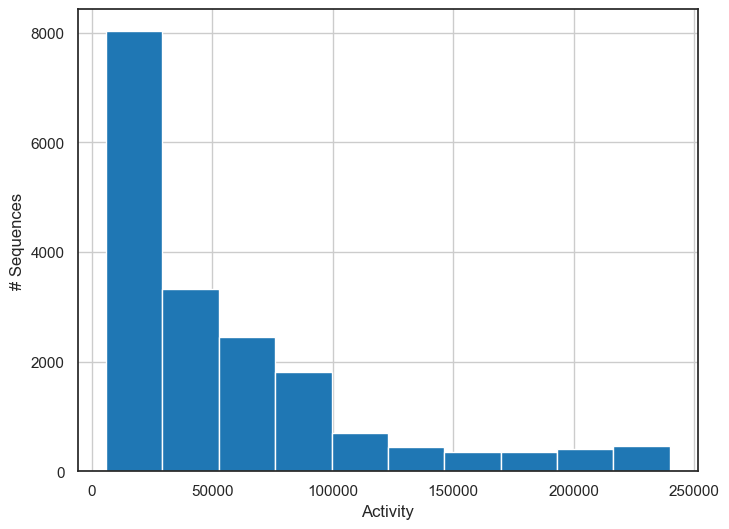

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
df.Activity.hist(ax=ax)
ax.set(xlabel="Activity")
ax.set(ylabel="# Sequences")
sns.set_context('poster')

In [4]:
# Create Training and Validation Datasets
pl.seed_everything(0)

bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

Global seed set to 0


## Rewrite the Model

In [5]:
from torchmetrics import MeanSquaredError, PearsonCorrCoef, SpearmanCorrCoef
from actpred.models import ResBlock
import torch.nn as nn
# from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as Fun


class ActCNNOneHot(nn.Module):

    def __init__(self,
                 hidden,
                 kernel_size,
                 dilation,
                 num_res_blocks=3,
                 seq_len=40):
        super(ActCNNOneHot, self).__init__()
        # self.enc = OneHotEncoder()
        self.emb = nn.Linear(20, hidden, bias=False)
        # self.emb = nn.Embedding(20, embedding_dim=hidden, dtype=torch.float32)
        self.conv_init = nn.Conv1d(in_channels=hidden,
                                   kernel_size=kernel_size,
                                   out_channels=hidden,
                                   padding="same")
        self.res_blocks = nn.ModuleList([
            ResBlock(hidden, kernel_size, dilation)
            for _ in range(num_res_blocks)
        ])
        self.pool = nn.MaxPool1d(kernel_size=seq_len)
        self.lin = nn.Linear(hidden, 1)

    def forward(self, X):
        # enc = self.enc.fit(X)
        # X = torch.tensor(enc.transform(X).toarray(), device=self.device)
        X = Fun.one_hot(X, num_classes=20).float()
        out = self.emb(X)
        out = out.transpose(2, 1)
        out = self.conv_init(out)
        for res_block in self.res_blocks:
            out = res_block(out)
        out = self.pool(out).squeeze()
        out = self.lin(out)
        return out


class ActCNNOneHotSystem(pl.LightningModule):

    def __init__(self,
                 hidden,
                 kernel_size,
                 dilation,
                 num_res_blocks=3,
                 seq_len=40,
                 weight_decay=1e-2):
        super(ActCNNOneHotSystem, self).__init__()
        self.save_hyperparameters()
        self.wd = weight_decay
        self.model = ActCNNOneHot(hidden,
                            kernel_size,
                            dilation,
                            seq_len=seq_len,
                            num_res_blocks=num_res_blocks)
        self.loss_fn = nn.MSELoss()

        self.rmse = MeanSquaredError(squared=False)
        self.pearsonr = PearsonCorrCoef()
        self.spearmanr = SpearmanCorrCoef()
        self.metrics = {
            "rmse": self.rmse,
            "pearsonr": self.pearsonr,
            "spearmanr": self.spearmanr
        }

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=1e-3,
                                     weight_decay=self.wd)
        return optimizer

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        loss = self.loss_fn(y_pred, y)
        return {
            "loss": loss,
            "y_target": y.view(-1),
            "y_pred": y_pred.detach().view(-1),
        }

    def training_epoch_end(self, train_step_outputs):
        y_preds = [d['y_pred'] for d in train_step_outputs]
        y_targets = [d['y_target'] for d in train_step_outputs]
        y_preds = torch.concat(y_preds)
        y_targets = torch.concat(y_targets)

        train_loss = self.metrics['rmse'](y_preds, y_targets)
        for metric_name, metric in self.metrics.items():
            metric_name = "train_" + metric_name
            self.log(metric_name, metric(y_preds, y_targets))
        return

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        return (y_pred.view(-1), y.view(-1))

    def validation_epoch_end(self, val_step_outputs):
        y_preds, y_targets = zip(*val_step_outputs)
        y_preds = torch.concat(y_preds)
        y_targets = torch.concat(y_targets)

        val_loss = self.metrics['rmse'](y_preds, y_targets)
        self.log("val_loss", val_loss)
        for metric_name, metric in self.metrics.items():
            metric_name = "val_" + metric_name
            print(metric_name, metric(y_preds, y_targets).item(), flush=True)
            self.log(metric_name, metric(y_preds, y_targets))
        return val_loss

In [6]:
Fun.one_hot(torch.tensor(1), num_classes=20)

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model = ActCNNOneHotSystem(hidden, kernel_size, dilation, num_res_blocks=3)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNNOneHot     | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearma

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 31.89it/s]val_rmse 1.108262062072754
val_pearsonr 0.08557015657424927
val_spearmanr 0.11010280251502991
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 130/130 [00:01<00:00, 72.87it/s, loss=0.513, v_num=16]val_rmse 0.7239258885383606
val_pearsonr 0.7082771062850952
val_spearmanr 0.6427605152130127
Epoch 1: 100%|██████████| 130/130 [00:01<00:00, 88.96it/s, loss=0.43, v_num=16] val_rmse 0.6866971254348755
val_pearsonr 0.7384626865386963
val_spearmanr 0.6506236791610718
Epoch 2: 100%|██████████| 130/130 [00:01<00:00, 83.02it/s, loss=0.429, v_num=16]val_rmse 0.6867619752883911
val_pearsonr 0.746609091758728
val_spearmanr 0.6745498180389404
Epoch 3: 100%|██████████| 130/130 [00:01<00:00, 86.83it/s, loss=0.378, v_num=16]val_rmse 0.6769113540649414
val_pearsonr 0.7471845149993896
val_spearmanr 0.6858740448951721
Epoch 4: 100%|██████████| 130/130 [00:01<00:00, 81.73it/s, loss=0.379, v_num=16]val_rmse 0.6655571460723877
val_pearsonr 0.7641998529434204
val_spearmanr 0.6956622004508972
Epoch 5: 100%|██████████| 130/130 [00:01<00:00, 83.10it/s, loss=0.366, v_num=16]val_rmse 0.6811713576316833
val_pearsonr 0.7604072093963

In [8]:
# get best model and save it
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
torch.save(model.cpu().state_dict(), "adhunter_1he.pt")

In [9]:
# Load model 
model = ActCNNOneHotSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter_1he.pt"))

<All keys matched successfully>

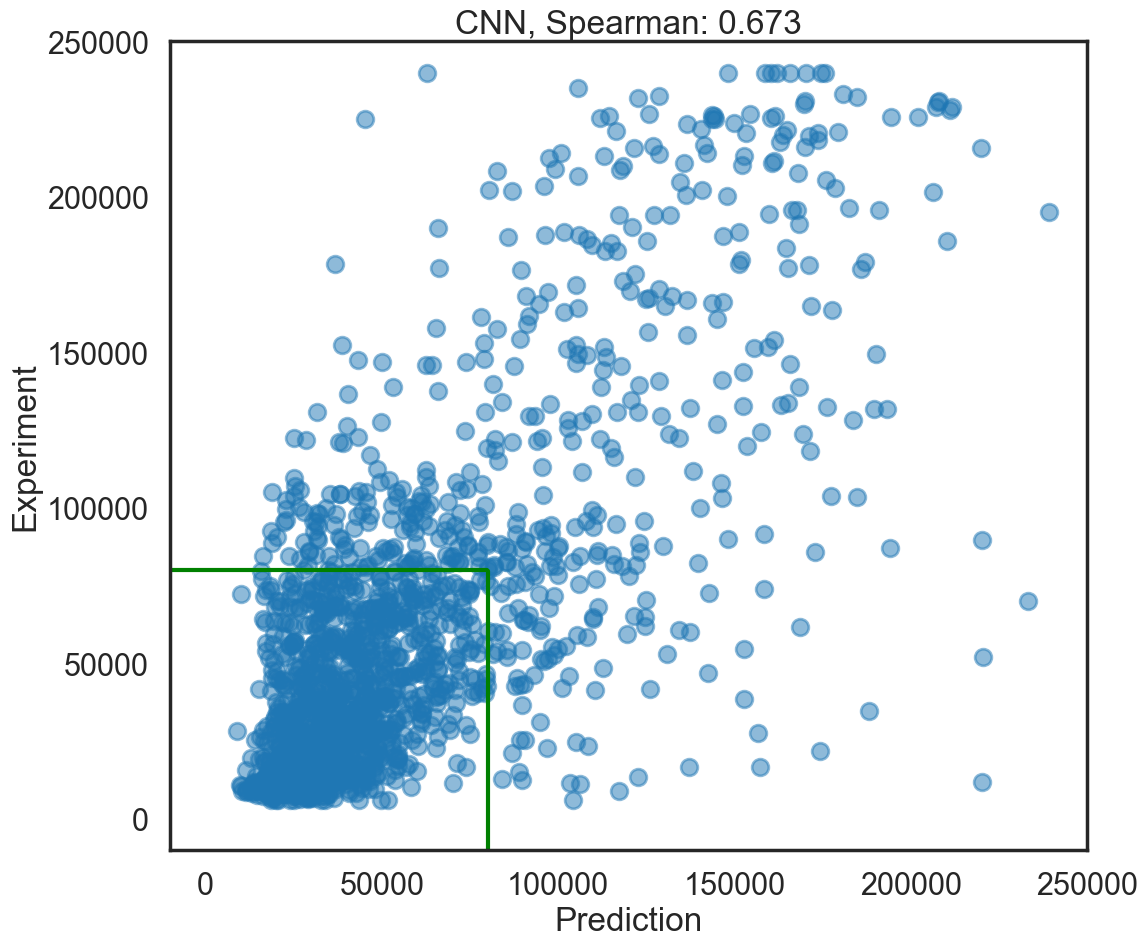

In [10]:
test_ds = TensorDataset(X_test, y_cont_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model.eval()
X_test, y_test = test_ds[:]
y_test = y_test.reshape(-1)
with torch.no_grad():
    y_test_hat = model(X_test).reshape(-1)
    y_test_hat = y_test_hat.detach().numpy()
    y_test = y_test.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat)
best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(y_test_hat_unscaled, y_test_unscaled, alpha=0.5)
corr = spearmanr(y_test_hat_unscaled, y_test_unscaled).correlation
ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Spearman: {corr:.3f}")
ax.set(xlim=(-10000, 250_000), ylim=(-10000, 250_000))
plt.tight_layout()
plt.axvline(x=80_000, c='green', ymax=0.345)
plt.axhline(y=80_000, c='green', xmax=0.345)
plt.show()

# Captum DeepLIFT

In [11]:
weak = "PTPEAFAADTITRFQTTANTQVSSPCSFRSIERNQFRRSS"
strong = "IEESMDECIRWLENPFLNQFIAGFDLIGEEATEKHPLIYH"
def encode(seq):
    assert len(seq) == 40, "Sequence must be 40 AA!"
    return torch.tensor([[aa_to_i[i] for i in seq]], dtype=torch.int64)

# model(encode(weak))
print(encode(weak))
print(model(encode(strong)))
# sample_input

tensor([[12, 16, 12,  3,  0,  4,  0,  0,  2, 16,  7, 16, 14,  4, 13, 16, 16,  0,
         11, 16, 13, 17, 15, 15, 12,  1, 15,  4, 14, 15,  7,  3, 14, 11, 13,  4,
         14, 14, 15, 15]])
tensor([1.5230], grad_fn=<ViewBackward0>)


In [ ]:
from captum.attr import LayerDeepLift


sample_input = torch.randint(0, 20, (1, 40), dtype=torch.int64)
baseline = torch.zeros_like(sample_input, dtype=torch.int64)
dl = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=False,)
# Attribute a random vector
# TODO: Make a function, add AA as row names and REMOVE from plotting fxn
attr = dl.attribute(sample_input, baselines=baseline, attribute_to_layer_input=True)
attr = attr.detach().numpy()[0]
attr_df = pd.DataFrame(attr).T
print(attr.shape)

(40, 20)


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
attr_train = dl.attribute(X_train, baselines=baseline, attribute_to_layer_input=True)
attr_train_df = pd.DataFrame(attr_train.mean(axis=0)).T

In [ ]:
attr_test = dl.attribute(X_test, baselines=baseline, attribute_to_layer_input=True)
attr_test_df = pd.DataFrame(attr_test.mean(axis=0)).T

In [ ]:
attr_full = dl.attribute(0, baselines=baseline, attribute_to_layer_input=True)
attr_full_df = pd.DataFrame(attr_full.mean(axis=0)).T

In [16]:
sns.reset_defaults()

In [67]:
def plot_attr(df, alphabet="ACDEFGHIKLMNPQRSTVWY", ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap="bwr", center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(list(alphabet), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax

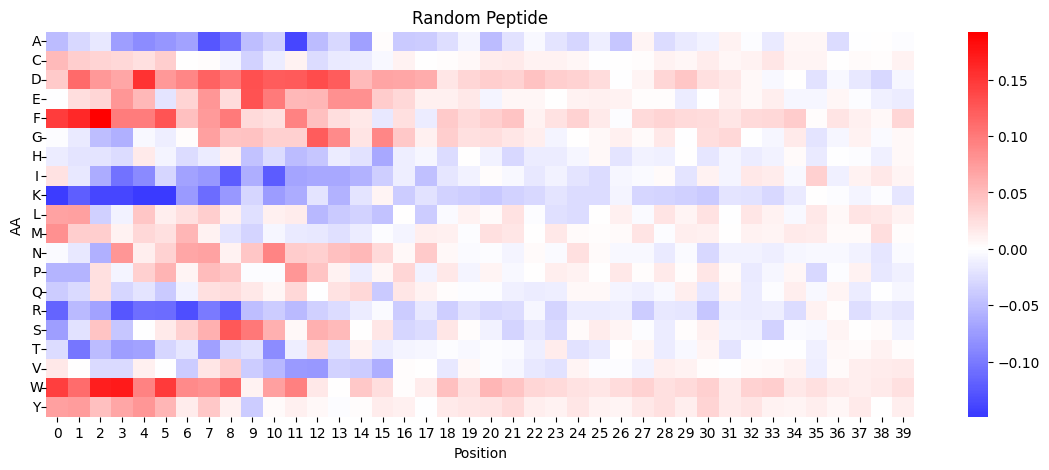

In [73]:
plot_attr(attr_df, title="Random Peptide")
plt.show()

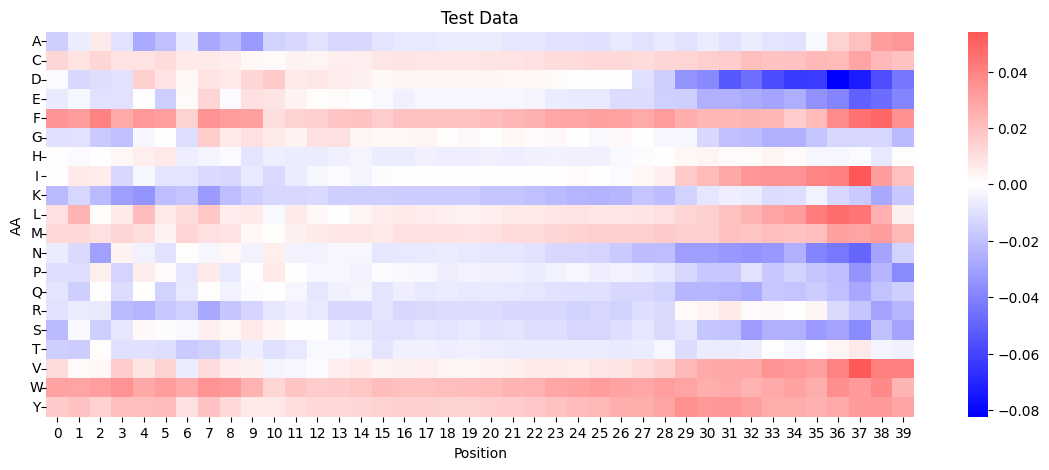

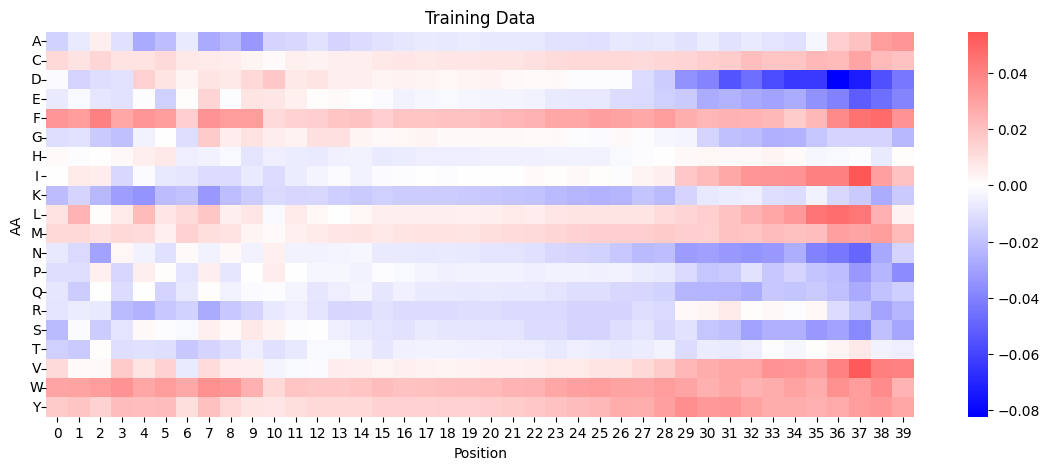

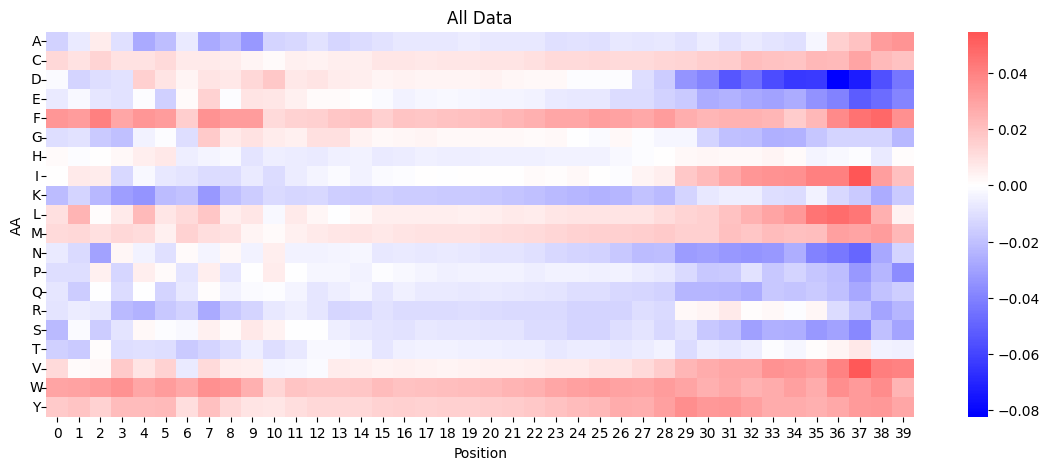

In [ ]:
plot_attr(attr_test_df, title="Test Data")
plt.show()
plot_attr(attr_train_df, title="Training Data")
plt.show()
plot_attr(attr_full_df, title="All Data")
plt.show()

In [ ]:
resn_props = {
    "acidic": ["D", "E"],
    "hydrophobic": ["A", "V", "I", "L", "M", "F", "Y", "W"],
    "aromatic": ["F", "Y", "W"]
}


## TODO
- Importance | Activator
- Importance | Acidic resn present
- Importance | Hydrophobic resn present
- Importance | Aromatic resn present

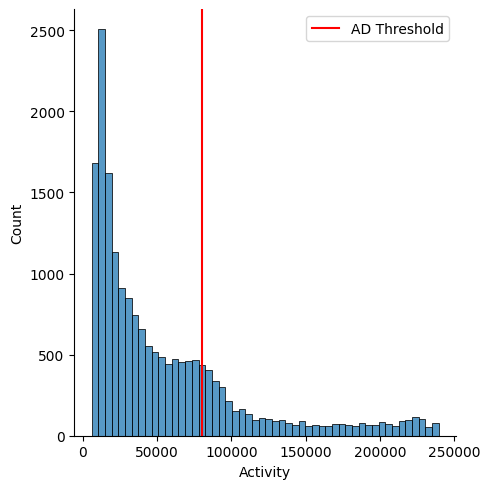

In [62]:
sns.displot(df["Activity"])#, kind="kde")
ad_threshold = 80_000
plt.axvline(ad_threshold, c='r', label="AD Threshold")
plt.legend()
plt.show()

In [75]:
X_ad = torch.tensor(X[np.where(df["Activity"] >= ad_threshold)[0]])
attr_ad = dl.attribute(X_ad, baselines=baseline, attribute_to_layer_input=True)
attr_ad_df = pd.DataFrame(attr_ad.mean(axis=0)).T

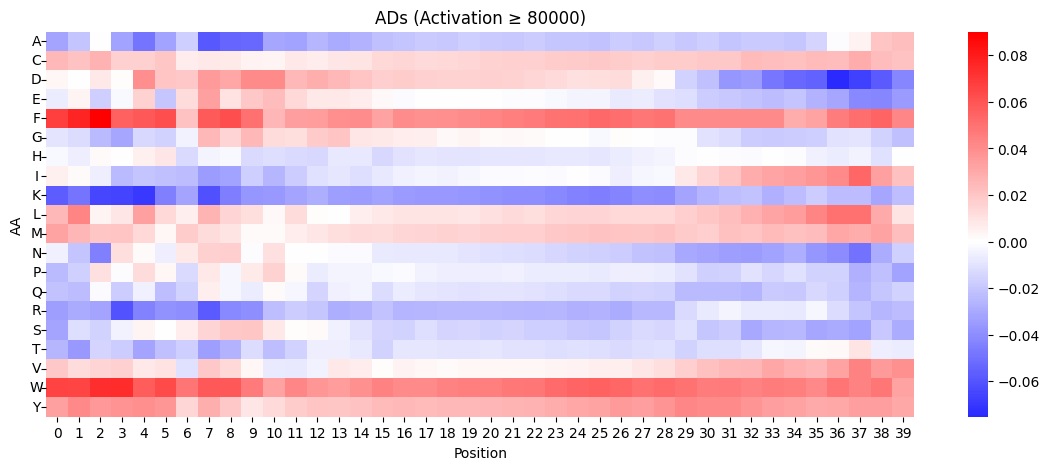

In [77]:
plot_attr(attr_ad_df, title=f"ADs (Activation \u2265 {ad_threshold})")
plt.show()

In [90]:
attr_ad_df.index = list(alphabet)

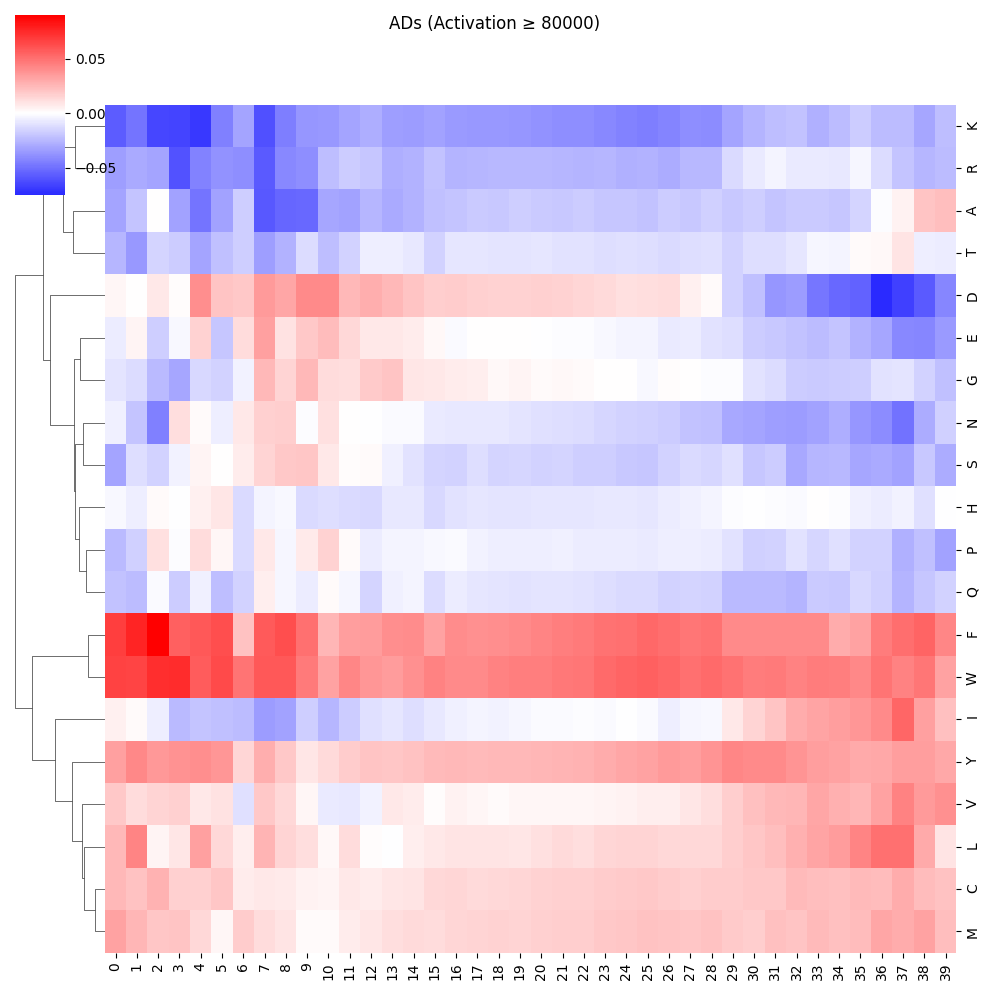

In [94]:
sns.clustermap(attr_ad_df, 
               col_cluster=False, cmap="bwr", center=0,
               dendrogram_ratio=.1,
               )
# print(plt.yticklabels())
plt.suptitle(f"ADs (Activation \u2265 {ad_threshold})")
plt.show()